# ATIS Project

In [126]:
import os
import sys
import collections
import random
import pickle
import shutil
import math
import nltk
import re
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
from numpy.random import randint

import sklearn
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.python.client import device_lib

print(sys.version)

3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]


# Data Ingestion

In [2]:
with open('atis-2.train.w-intent.iob') as f:
    train_file = f.read()

In [3]:
with open('atis-2.dev.w-intent.iob') as f:
    test_file = f.read()

**Simplifying Assumption:** When an utterance has multiple intentions we will only try to predict the first intention.  

The goal of the ATIS corpus was to route calls [1]. Since a multi-intent utterance would have to be routed to a single intent channel initially, this seems like a fair assumption.  Additionally, this assumption has a small impact, as multi-intent utterances only make up 0.5% of the training data set.

[1] [What is left to be understood in ATIS](https://ieeexplore.ieee.org/document/5700816/)

In [21]:
def parse_atis(file):
    
    #removing '.'s and '-'s so that labes are treated as a single word
    file = file.replace('.','_')
    file = file.replace('-','_')
    
    lines = file.split('\n')

    utter_label_pairs = [line.split('\t') for line in lines[:-1]]
    utters = [pair[0] for pair in utter_label_pairs]
    labels = [pair[1] for pair in utter_label_pairs]
    
    #extracting intentions
    #only keeping first intention in multi-intention cases
    intentions = [label[-len(label.split()[-1]):] for label in labels]
    intentions = [intent.split('#')[0] for intent in intentions]
    
    #removing leading 'BOS ' and trailing ' EOS'
    utters = [utter[4:] for utter in utters if utter[:4] == 'BOS ']
    utters = [utter[:-4] for utter in utters if utter[-4:] == ' EOS']
    
    #removing first 'O ' and trailing intent
    labels = [label[2:] for label in labels if label[:2] == 'O ']
    labels = [label[:-(len(label.split()[-1]) + 1)] for label in labels]

    for each_line in range(len(utter_label_pairs)):
        assert len(utters[each_line].split()) == len(labels[each_line].split())

    df = pd.DataFrame([utters,labels,intentions]).T
    df.columns = ['utter','label','intent']
    
    return df

In [22]:
train_df = parse_atis(train_file)
test_df = parse_atis(test_file)

train_df.head()

,utter,label,intent
0,i want to fly from baltimore to dallas round trip,O O O O O B_fromloc_city_name O B_toloc_city_n...,atis_flight
1,round trip fares from baltimore to philadelphi...,B_round_trip I_round_trip O O B_fromloc_city_n...,atis_airfare
2,show me the flights arriving on baltimore on j...,O O O O O O B_toloc_city_name O B_arrive_date_...,atis_flight
3,what are the flights which depart from san fra...,O O O O O O O B_fromloc_city_name I_fromloc_ci...,atis_flight
4,which airlines fly from boston to washington d...,O O O O B_fromloc_city_name O B_toloc_city_nam...,atis_airline


### Data Inspection

Utterance examples

In [18]:
for row_n in randint(0, train_df.shape[0], 10):
    print(train_df.loc[row_n,'utter'])

what flights go from newark to boston after 5 pm
what northwest airline flights leave denver before noon
show flights from philadelphia to boston
i would like information on ground transportation city of boston between airport and downtown
hi i'd like a flight from tampa to montreal
find travel arrangements for a round trip flight from boston to pittsburgh
i now need a flight from san jose to houston leaving on sunday the fourth
please list the flights for me that leave dallas on tuesday morning and arrive in atlanta
all flights from denver to pittsburgh leaving after 6 pm and before 7 pm
show me flights on wednesday morning boston to denver for united airlines first class


Utterances with their labels

In [13]:
for row_n in randint(0,train_df.shape[0],5):
    
    print(pd.DataFrame(
            [train_df.loc[row_n,'utter'].split(),
             train_df.loc[row_n,'label'].split()])
          .to_string(index=False, header=False))
    
    print(train_df.loc[row_n,'intent'], '\n')


show  me  all  flights  from           pittsburgh  to          baltimore  which  leave                thursday                        after                   3             o'clock                  pm
   O   O    O        O     O  B_fromloc_city_name   O  B_toloc_city_name      O      O  B_depart_date_day_name  B_depart_time_time_relative  B_depart_time_time  I_depart_time_time  I_depart_time_time
atis_flight 

i'd  like  to  find  a  flight  from                tampa  to           montreal  that  makes  a  stop  in                  new                 york
  O     O   O     O  O       O     O  B_fromloc_city_name   O  B_toloc_city_name     O      O  O     O   O  B_stoploc_city_name  I_stoploc_city_name
atis_flight 

please  list  the  flights  from               dallas                 fort                worth  to                  dc          baltimore  on                      july                    twenty                     third
     O     O    O        O     O  B_fromloc_city_name

Intent frequency distributsion. Heavily squed towards `atis_flight`

In [87]:
train_df.intent.value_counts() / train_df.shape[0]

atis_flight                                 0.738946
atis_airfare                                0.085976
atis_ground_service                         0.051362
atis_airline                                0.031041
atis_abbreviation                           0.029031
atis_aircraft                               0.015632
atis_flight_time                            0.010049
atis_quantity                               0.009156
atis_flight#atis_airfare                    0.004243
atis_city                                   0.004020
atis_distance                               0.003796
atis_airport                                0.003796
atis_ground_fare                            0.003350
atis_capacity                               0.003350
atis_flight_no                              0.002680
atis_meal                                   0.001340
atis_restriction                            0.001117
atis_airline#atis_flight_no                 0.000447
atis_cheapest                               0.

# Supervised Learning: "Machine-Learning" Approach
### Implement Bag of Words (BOW)

In [38]:
def bow(ngram, data, stop_words = None):
    
    vectorizer = (
        CountVectorizer(
            ngram_range=(1, ngram),
            stop_words = stop_words,
            min_df=1)
        .fit(data))
    
    bow_df = pd.DataFrame(vectorizer.transform(data).toarray(), 
                          columns = list(vectorizer.vocabulary_.keys()))
    
    return bow_df

In [68]:
bow_train_df = pd.concat(
    [bow(ngram = 2, data = train_df['utter'], stop_words = None),
     bow(ngram = 2, data = train_df['label'], stop_words = ['O']),
     train_df['intent']],
    axis=1) 

bow_test_df = pd.concat(
    [bow(ngram = 2, data = test_df['utter'], stop_words = None),
     bow(ngram = 2, data = test_df['label'], stop_words = ['O']),
     test_df['intent']],
    axis=1) 

bow_train_df.head()

,want,to,fly,from,baltimore,dallas,round,trip,want to,to fly,...,b_meal_description i_meal_description,i_arrive_time_time b_or,i_class_type b_arrive_date_month_name,b_transport_type b_fromloc_airport_name,i_fromloc_airport_name b_fromloc_city_name,b_or b_depart_date_day_number,b_depart_date_day_number b_mod,b_flight_stop b_airline_name,i_airline_name b_or,intent
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,atis_flight
1,0,0,0,0,0,0,0,3,3,0,...,0,0,0,0,0,0,0,0,0,atis_airfare
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,atis_flight
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,atis_flight
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,atis_airline


### Vizualizing Dimensionality Reduction
Generating plots to visualize intent category seperation under different bag of words implementations (```ngram```, ```stop_words```,normalization method, etc.).  It is interesting to find the locations of the misclassified intents (see ```mc.pairs.value_counts()``` below).  

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


explained variance ratio (first two components): [0.04476952 0.03576521]


Text(0.5,1,'LDA')

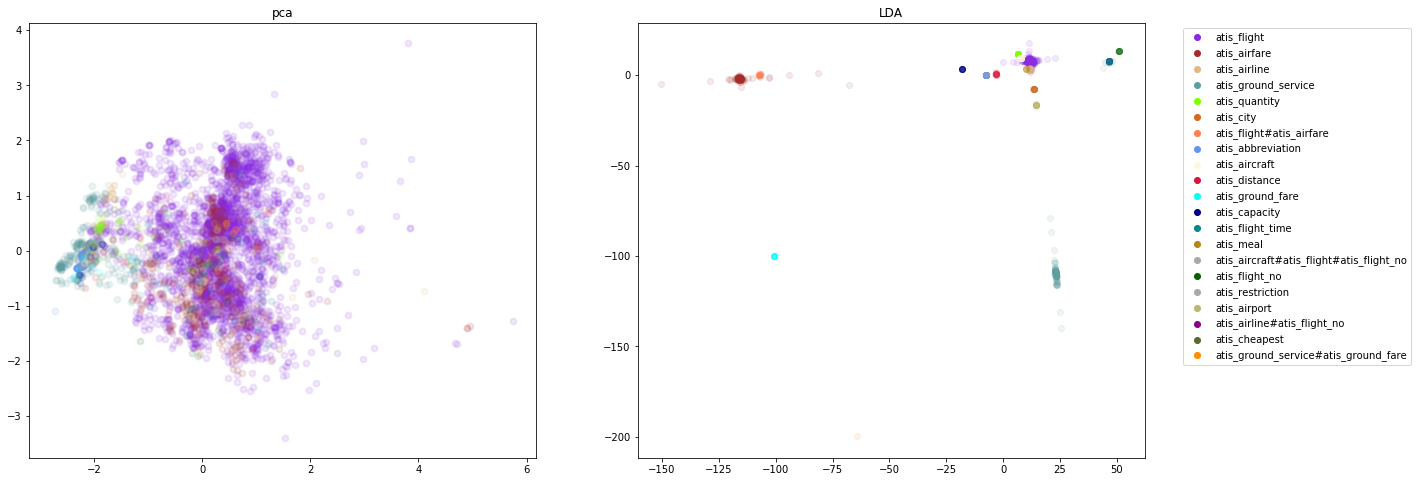

In [85]:
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
print(f'explained variance ratio of first two components: {pca.explained_variance_ratio_}')

# tsne = TSNE(n_components=2)
# X_r1 = tsne.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

color_palette = list(matplotlib.colors.CSS4_COLORS.keys())
target_names = bow_train_df.intent.unique()
colors = color_palette[10:len(target_names)+10]
target_name_index = list(range(len(target_names)))
lw = 2

plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
for color, target_name in zip(colors, target_names):
    plt.scatter(X_r[y == target_name, 0], X_r[y == target_name, 1], color=color, alpha=.1, lw=lw,
                label=target_name)
plt.title('pca')
#plt.title('t-SNE')

plt.subplot(1, 2, 2)
for color, target_name in zip(colors, target_names):
    plt.scatter(X_r2[y == target_name, 0], X_r2[y == target_name, 1], alpha=.1, color=color,
                label=target_name)
leg = plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=False, scatterpoints=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('LDA')

### Train, Test, Score Supervised Learning Model

Only a random forest model is implemented here.  More models can be implemented tuned and compared using well documented methods [2][3][4][5].  Time was spent working on neural network approach rather than eking out a lower error rate. 

[2] [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html),
[3] [TPOT](https://github.com/EpistasisLab/tpot),
[4] [H2O](https://github.com/h2oai/h2o-tutorials/blob/master/h2o-open-tour-2016/chicago/grid-search-model-selection.ipynb),
[5] [DataRobot (company)](https://www.datarobot.com/)

In [76]:
X = bow_train_df.drop('intent', axis=1)
y = bow_train_df['intent']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=.2,
                                                    train_size=.8)

rf = RandomForestClassifier(n_estimators = 100)
rf = rf.fit(X_train, y_train)

print(cross_val_score(rf, X_test, y_test, cv=5))

y_hat = rf.predict(X_test)
rf.score(X_test, y_test)

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.84946237 0.9076087  0.88888889 0.8908046  0.91860465]


0.953125

In [84]:
comparison = pd.DataFrame(list(zip(y_hat, y_test)),
                          columns = ['y_hat','y'])

#MisClassifications (mc)
mc = comparison[comparison.y != comparison.y_hat]
mc['pairs'] = mc.y_hat + ' : ' + mc.y

print('y_hat : y')
mc.pairs.value_counts()

y_hat : y


atis_flight : atis_airfare                10
atis_flight : atis_airline                 5
atis_ground_service : atis_ground_fare     4
atis_flight : atis_aircraft                2
atis_abbreviation : atis_aircraft          2
atis_airfare : atis_flight                 2
atis_flight : atis_flight_time             2
atis_airline : atis_flight                 1
atis_flight : atis_meal                    1
atis_abbreviation : atis_airline           1
atis_flight : atis_distance                1
atis_flight : atis_flight_no               1
atis_aircraft : atis_flight                1
atis_ground_service : atis_airport         1
atis_flight : atis_quantity                1
atis_airfare : atis_aircraft               1
atis_quantity : atis_flight                1
atis_aircraft : atis_meal                  1
atis_ground_service : atis_city            1
atis_abbreviation : atis_airfare           1
atis_flight : atis_ground_service          1
atis_ground_service : atis_distance        1
Name: pair

# Supervised Learning: Neural Network Approach

Attempted to implement the convolutional neural network (CNN) architecture described in [6] which used static word vectros.  Initially the plan was to use Google's pretrained word vectors from [7], however, it was too large to fit into my computer's 4GB of RAM.  Thus, word vectors are first trined in TensorFlow by following an example [8].  The word vectors are then concatenated to form the inputs for the CNN.  The CNN architecture is built and is compiled into a TensorFlow graph (using [9] as a framework).  Unfortunatly, my computer cannot train the CNN due to a GPU that does not meet TensorFlow's minimum requirements [10] and a CPU that does not the support necessary NHWC format of matrix multiplication [11].  While the CNN is not fully tested and its performance cannot be analyzed, it presents a feasible implementation of the architecture.

[6] [Convolutional Neural Networks for Sentence Classification](http://www.aclweb.org/anthology/D14-1181),
[7] [GoogleNews-vectors](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit),
[8] [TensorFlow word2vec Example](https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/examples/tutorials/word2vec/word2vec_basic.py),
[9] [TensorFlow CNN Example](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/convolutional_network.py),
[10] [TensorFlow GPU Requirements](https://www.tensorflow.org/install/install_windows),
[11] [TensorFlow Data Formats](https://www.tensorflow.org/performance/performance_guide#data_formats)

## Implement word2vec (Skip-Gram Model) 
Built of [8].  [12] and [13] were helpful to understand the mechanics.

One flaw is that ```build_dataset()``` treats the corpus like one long text rather than individual utterances.  Thus, the model incorrectly imposes that the the beginning and ending words of utterances should predict one another.  Given more time, this would be a high priority to fix. 

[8] [TensorFlow word2vec Example](https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/examples/tutorials/word2vec/word2vec_basic.py),
[12] [word2vec Parameter Learning Explained](https://arxiv.org/pdf/1411.2738.pdf),
[13] [Distributed Representations of Words and Phrases and their Compositionality](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

### Data Input and Batch Generation

In [100]:
def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            buffer.extend(data[0:span])
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [101]:
utter_vectorizer = CountVectorizer().fit(train_df['utter'])
vocabulary_size = len(utter_vectorizer.vocabulary_)
embedding_size = 128
batch_size = 8
skip_window = 1
num_skips = 2
num_sampled = 64  
validation_size = 16 
validation_window = 100 
validation_examples = np.random.choice(validation_window, validation_size, replace=False)

Example batch  

In [102]:
data, count, dictionary, reverse_dictionary = (
    build_dataset(
        ' '.join([x for x in train_df['utter']]).split(' '),
        vocabulary_size))

batch, labels = generate_batch(batch_size=8, 
                               num_skips=2,
                               skip_window=1)

for i in range(8):
    print(batch[i],
          reverse_dictionary [batch[i]], '->',
          labels[i, 0],
          reverse_dictionary [labels[i, 0]])

68 want -> 1 to
68 want -> 18 i
1 to -> 36 fly
1 to -> 68 want
36 fly -> 1 to
36 fly -> 2 from
2 from -> 22 baltimore
2 from -> 36 fly


### Building Skipgram

Noise-Contrastive Estimation (NCE) uses negative sampling to approximate a full softmax approach.  Advantage is a compute time independednt of vocabulary size. 

In [103]:
graph = tf.Graph()

with graph.as_default():
    with tf.name_scope('inputs'):
        
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        validation_dataset = tf.constant(validation_examples, dtype=tf.int32)

    with tf.name_scope('embeddings'):
        
        embeddings = (
            tf.Variable(
            tf.random_uniform(
                [vocabulary_size, embedding_size],
                -1.0, 1.0)))
        
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    with tf.name_scope('weights'):
        
        nce_weights = (
            tf.Variable(
            tf.truncated_normal(
                [vocabulary_size, embedding_size],
                stddev=1.0 / math.sqrt(embedding_size))))
    
    with tf.name_scope('biases'):
        
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    with tf.name_scope('loss'):
        
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=train_labels,
                inputs=embed,
                num_sampled=num_sampled,
                num_classes=vocabulary_size))
    
    tf.summary.scalar('loss', loss) 
    
    with tf.name_scope('optimizer'):
        
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    
    normalized_embeddings = embeddings / norm
    
    validation_embeddings = tf.nn.embedding_lookup(normalized_embeddings,validation_dataset)
    
    similarity = tf.matmul(validation_embeddings, 
                           normalized_embeddings,
                           transpose_b=True)
    
    merged = tf.summary.merge_all()
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

### Train skipgram

In [106]:
if os.path.isdir('logs'):
    shutil.rmtree('logs')
    
os.makedirs('logs', exist_ok = True)

#loss levels out ater 80000 steps
num_steps = 80001

with tf.Session(graph=graph) as session:
    
    writer = tf.summary.FileWriter('logs', session.graph)

    init.run()
    print('Initialized')
    
    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips,
                                                    skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        run_metadata = tf.RunMetadata()
        
        _, summary, loss_val = session.run(
            [optimizer, merged, loss],
            feed_dict=feed_dict,
            run_metadata=run_metadata)
        
        average_loss += loss_val
        
        writer.add_summary(summary, step)

        if step == (num_steps - 1):
            writer.add_run_metadata(run_metadata, f'step{step}')

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
                print(f'Average loss at step {step}: ', average_loss)
                average_loss = 0
                
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(validation_size):
                validation_word = reverse_dictionary[validation_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = f'Nearest to {validation_word}:'
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = f'{log_str} {close_word},'
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

    with open('logs' + '/metadata.tsv', 'w') as f:
        for i in range(vocabulary_size):
            f.write(reverse_dictionary[i] + '\n')

    saver.save(session, os.path.join('logs', 'model.ckpt'))

    config = projector.ProjectorConfig()
    embedding_conf = config.embeddings.add()
    embedding_conf.tensor_name = embeddings.name
    embedding_conf.metadata_path = os.path.join('logs', 'metadata.tsv')
    projector.visualize_embeddings(writer, config)

writer.close()

session.close()

Initialized
Nearest to las: from, 217, heading, name, carolina, qx, 315, eight,
Nearest to delta: 500, world, where, salt, people, midnight, dl, beginning,
Nearest to way: december, list, connect, that's, code, bur, trips, other,
Nearest to round: twentieth, 1030, make, connecting, night, general, across, reservations,
Nearest to please: c, sixteenth, number, coming, offered, qo, reservation, still,
Nearest to philadelphia: them, charlotte, looking, prices, distance, express, nighttime, i,
Nearest to list: angeles, way, m, nw, midnight, ticket, express, fort,
Nearest to nonstop: 57, worth, first, sunday, jersey, least, car, which,
Nearest to first: expensive, missouri, nonstop, saturday, heading, los, either, montreal,
Nearest to one: 420, great, your, sd, it's, 771, s, ohio,
Nearest to afternoon: today, goes, york, one's, represented, provided, 1505, regarding,
Nearest to before: advertises, toronto, operating, canada, 505, pittsburgh, 1115, 225,
Nearest to want: 1245, too, friends, y

Average loss at step 52000:  3.560661081433296
Average loss at step 54000:  3.5420215358734133
Average loss at step 56000:  3.5523190506994724
Average loss at step 58000:  3.519342445999384
Average loss at step 60000:  3.5367540891766547
Nearest to las: st_, kansas, denver, san, miami, salt, new, charlotte,
Nearest to delta: united, continental, american, canadian, eastern, lufthansa, northwest, twa,
Nearest to way: cheapest, class, trip, expensive, trips, numbers, miami, go,
Nearest to round: one, layover, 1024, vicinity, them, fares, show, listing,
Nearest to please: pennsylvania, now, them, for, tell, you, 2134, can,
Nearest to philadelphia: denver, atlanta, pittsburgh, baltimore, dallas, boston, oakland, charlotte,
Nearest to list: vicinity, display, find, me, mealtime, listing, 130, for,
Nearest to nonstop: afternoon, 1026, travels, numbers, wanted, mealtime, first, direct,
Nearest to first: economic, prices, seats, kind, 1030, nonstop, round, fare,
Nearest to one: round, 1288, fa

### Visualize Word Vectors

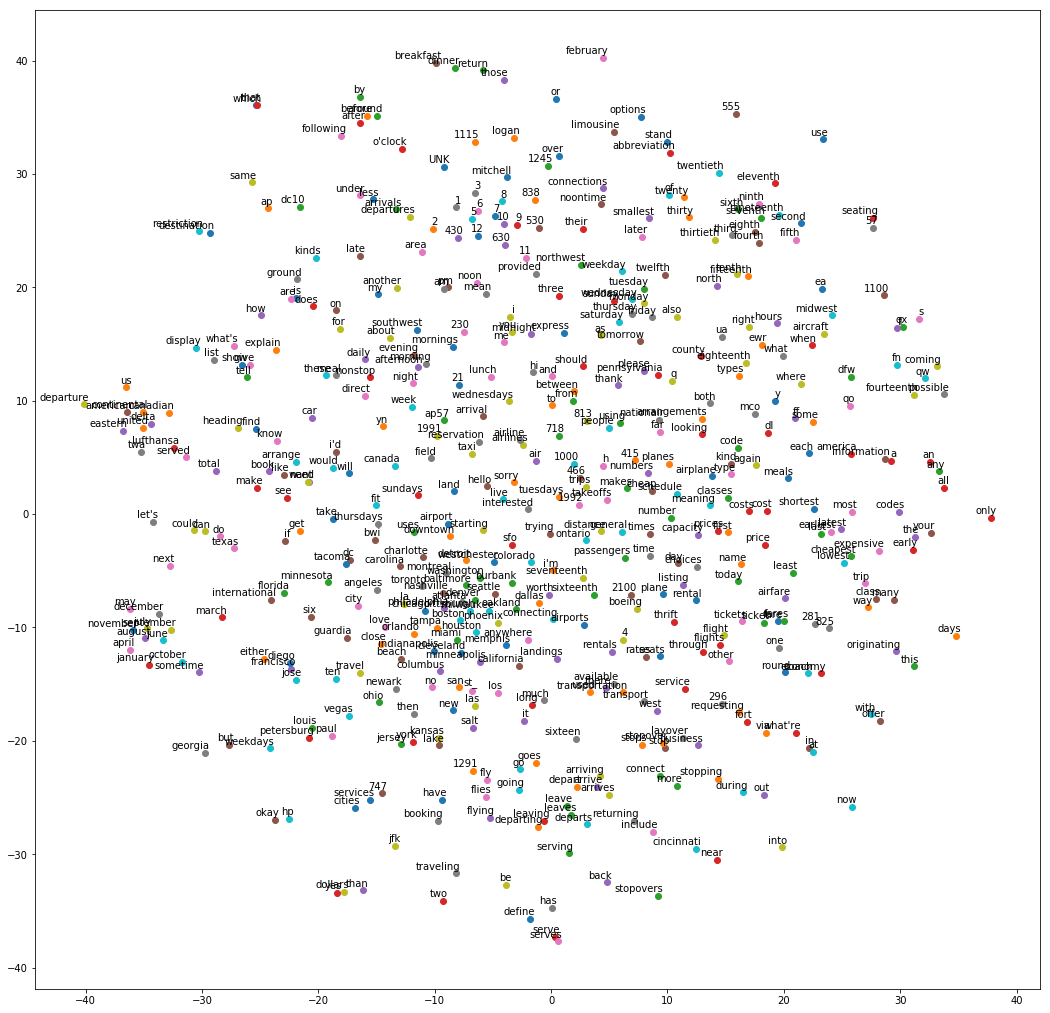

In [107]:
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')

    plt.savefig(filename)
    
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels, 'tsne.png')

Save the ```final_embeddings```

In [109]:
with open('final_embedding.pkl', 'wb') as f:
    pickle.dump(final_embeddings, f)
    
with open('final_embedding.pkl', 'rb') as f:
    final_embedding_load = pickle.load(f)

## Implement CNN Architecture

Attempt at implementing the CNN architecture described in [6]:

![architecture](architecture.png)

1. The input is a matrix is formed by concatenating the word vectors (as rows) in the order they appear in the utterence
2. Convolutional layers apply filters to sequences of word vectos
3. Max pooling layer
4. Fully connected layer
5. Softmax classifier

[6] [Convolutional Neural Networks for Sentence Classification](http://www.aclweb.org/anthology/D14-1181)

### Create Utter Matrices by Concatenating Word Vectors

In [116]:
#utter_length_counts (ulc)
ulc = (
    pd.DataFrame(
    train_df['utter']
    .apply(lambda row: len(row.split(' ')))
    .value_counts()
    .sort_index())
    .rename({'utter':'utter_lengths'}, axis = 'columns'))

ulc['cum_sum'] = ulc['utter_lengths'].cumsum()
ulc['cum_perc'] = 100 * ulc.cum_sum / ulc['utter_lengths'].sum()

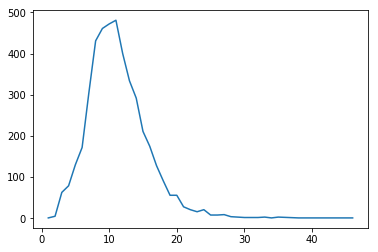

In [117]:
ulc['utter_lengths'].plot()

Append utter matrices.

Zeros vectors are padded onto the bottom of the matrix to make all matrices the same shape (46 rows to match the length of the longest utterance).  While memory inefficent, the architecture does handle varying utterance length in a clever fashion.  It is interesting to think about how to cut the input matrix rows down to ~25 (99% of the utterances have ```len() < 25``` see graph above).

In [118]:
max_utter_length = max(ulc.index)

l = []
for utter in train_df['utter']:
    
    try:
        utter_matrix = np.matrix(
            [final_embeddings[dictionary[word]]
             for word
             in utter.split()
             if word in dictionary])

        n_row = utter_matrix.shape[0]

        utter_matrix = np.append(
            utter_matrix,
            np.zeros([max_utter_length - n_row, embedding_size]),
            axis = 0)

        assert utter_matrix.shape == (max_utter_length,embedding_size)
        
        l.append(utter_matrix)
        
    except:
        print('failed to create utter matrix for:', utter)
    
train_df['utter_matrix'] = l

Append utter matrices as vectors (easier ingestion into TensorFlow)

In [122]:
max_utter_length = max(ulc.index)

l = []
for utter in train_df['utter']:

    try:
        a = np.array([])
        for word in utter.split():
            if word in dictionary:
                a = np.append(a, final_embeddings[dictionary[word]])

        a = np.append(a,
                      np.zeros((max_utter_length * embedding_size) - len(a)))

        assert a.shape == (5888,)
        
    except:
        print('failed to create utter array for:', utter)
    
    l.append(a)
    
train_df['utter_array'] = l

Create a numeric representation of the intent categories

In [132]:
numeric_intent_map = dict(zip(list(train_df['intent'].unique()),range(num_classes)))

train_df['numeric_intent'] = train_df['intent'].apply(lambda row: numeric_intent_map[row])

train_df.head()

,utter,label,intent,utter_array,utter_matrix,numeric_intent
0,i want to fly from baltimore to dallas round trip,O O O O O B_fromloc_city_name O B_toloc_city_n...,atis_flight,"[0.12604328989982605, 0.0662437304854393, 0.04...",[[[[[ 0.12604329 0.06624373 0.0424179 -0.11...,0
1,round trip fares from baltimore to philadelphi...,B_round_trip I_round_trip O O B_fromloc_city_n...,atis_airfare,"[0.1489981859922409, 0.0821458101272583, 0.155...",[[[[[ 1.48998186e-01 8.21458101e-02 1.554080...,1
2,show me the flights arriving on baltimore on j...,O O O O O O B_toloc_city_name O B_arrive_date_...,atis_flight,"[0.0722881555557251, 0.20996955037117004, -0.0...",[[[[[ 0.07228816 0.20996955 -0.04089939 -0.14...,0
3,what are the flights which depart from san fra...,O O O O O O O B_fromloc_city_name I_fromloc_ci...,atis_flight,"[0.04388387128710747, 0.11702536791563034, -0....",[[[[[ 0.04388387 0.11702537 -0.05432782 -0.05...,0
4,which airlines fly from boston to washington d...,O O O O B_fromloc_city_name O B_toloc_city_nam...,atis_airline,"[0.028896957635879517, 0.09213770180940628, 0....",[[[[[ 0.02889696 0.0921377 0.02244959 -0.12...,2


### Implementing CNN Architecture

In [134]:
# Training Parameters
learning_rate = 0.001
num_steps = 1000
batch_size = 50

# Network Parameters
input_shape = train_df['utter_matrix'][0].shape
print(f'input_shape = {input_shape}')

num_input = len(train_df['utter_array'][0])
print(f'num_input = {num_input}')

num_classes = len(train_df['intent'].unique())
print(f'num_classes = {num_classes}')

dropout = 0.5

def get_available_divices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

get_available_divices()

input_shape = (46, 128)
num_input = 5888
num_classes = 21


['/device:CPU:0']

### Summary of Architecture

1. ```x.shape: [50, 46, 128, 1]```

Input Tensor. [NHWC] format.

[Batch size (N) of 50, Height (H) of 46 (length of longest sentence), Width (W) of 128, Channel count (C) of 1]

2. ```window_3_conv.shape: [50, 44, 1, 100]```

Convolution layer output.  Filter shape is (3,128) which represents 3 consecutive words.  Thus the width dimension vanishes and height is decreased by 2.  100 filters are applied.

3. ```window_3_conv_reshaped.shape: [50, 44, 100]```

Tensor is reshaped to eliminate the width dimension which vanished.

4. ```window_3_conv_reshaped_pooled.shape: [50, 1, 100]```

Max pooling is applied, and thus the height dimension vanishes.

5. ```window_3_flattened.shape: [50, 100]```

Tensor is reshaped to eliminate height dimension which vanished.

6. Steps 2-5 are repeated for a window of 4 and 5 words:

```
window_4_conv.shape: [50, 43, 1, 100]
window_4_conv_reshaped.shape: [50, 43, 100]
window_4_conv_reshaped_pooled.shape: [50, 1, 100]
window_4_flattened.shape: [50, 100]
    
window_5_conv.shape: [50, 42, 1, 100]
window_5_conv_reshaped.shape: [50, 42, 100]
window_5_conv_reshaped_pooled.shape: [50, 1, 100]
window_5_flattened.shape: [50, 100]
```
   
7. ```flat_all.shape: [50, 300]```

The flattened outputs (```window_n_flattened.shape: [50, 100]``` for ```n = 3, 4, 5```) are concatenated.

8. ```fc1.shape: [50, 1024]```

Fully connected layer expands from 300 to 1024 neurons.

9. ```out.shape: [50, 21]``` 

Fully connected layer for softmax of the 21 intent categories.

### TensorFlow Implementation of Architecture (does not run fully)

In [128]:
def conv(x, window):
    conv = tf.layers.conv2d(inputs = x, 
                                     filters = 100,
                                     kernel_size = (window,embedding_size), 
                                     #bias_initializer = ,
                                     data_format = 'channels_last', 
                                     activation=tf.nn.relu)        
    print(f'window_{window}_conv.shape:', conv.get_shape().as_list())

    conv_reshaped = tf.reshape(conv, shape=[50, -1, 100])
    print(f'window_{window}_conv_reshaped.shape:', conv_reshaped.get_shape().as_list())

    conv_reshaped_pooled = tf.layers.max_pooling1d(inputs = conv_reshaped, 
                                                    pool_size = (max_utter_length-window+1),
                                                    strides = 1,
                                                    data_format = 'channels_last')
    print(f'window_{window}_conv_reshaped_pooled.shape:', conv_reshaped_pooled.get_shape().as_list())

    flattened = tf.contrib.layers.flatten(conv_reshaped_pooled)
    print(f'window_{window}_flattened.shape:', flattened.get_shape().as_list())
    
    return flattened

def cnn(x_dict, n_classes, dropout, reuse, is_training):

    with tf.variable_scope('cnn', reuse=reuse):
        
        x = x_dict['utter_array']
        x = tf.reshape(x, shape=[-1, input_shape[0], input_shape[1], 1])
        print('x.shape:', x.get_shape().as_list())

        flat_3 = conv(x = x, window = 3) 
        flat_4 = conv(x = x, window = 4)
        flat_5 = conv(x = x, window = 5)
        
        flat_all = tf.concat([flat_3, flat_4, flat_5], 1)
        print('flat_all.shape:', flat_all.get_shape().as_list())

        fc1 = tf.layers.dense(flat_all, 1024)
        print('fc1.shape:', fc1.get_shape().as_list())

        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)
        out = tf.layers.dense(fc1, n_classes)
        print('out.shape:', out.get_shape().as_list())

    return out

def model_fn(features, labels, mode):
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = cnn(features, num_classes, dropout, reuse=False,
                            is_training=True)
    
    logits_test = cnn(features, num_classes, dropout, reuse=True,
                           is_training=False)

    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)

    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes)

        # Define loss and optimizer
    loss_op = (
        tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=logits_train,
                labels=tf.cast(labels, dtype=tf.int32))))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op,
                                  global_step=tf.train.get_global_step())

    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=pred_classes,
        loss=loss_op,
        train_op=train_op,
        eval_metric_ops={'accuracy': acc_op})

    return estim_specs

model = tf.estimator.Estimator(model_fn)

input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'utter_array': np.array([x for x in train_df['utter_array']])}, 
        y=np.array([x for x in train_df['numeric_intent']]), #likely need to map to numbers
        batch_size=batch_size,
        num_epochs=None, 
        shuffle=True)

model.train(input_fn, steps=num_steps)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Josh\\AppData\\Local\\Temp\\tmprtyhkn2i', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002279132FFD0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
x.shape: [50, 46, 128, 1]
window_3_conv.shape: [50, 44, 1, 100]
window_3_conv_reshaped.shape: [50, 44, 100]
window_3_conv_reshaped_pooled.shape: [50, 1, 100]
window_3_flattened.shape: [50, 100]
window_4_conv.shape: [50, 43, 1, 100]
window_4_conv_re

NotFoundError: No registered '_MklConv2DWithBias' OpKernel for CPU devices compatible with node cnn/conv2d_1/BiasAdd = _MklConv2DWithBias[T=DT_DOUBLE, _kernel="MklOp", data_format="NHWC", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](cnn/Reshape, cnn/conv2d_1/kernel/read, cnn/conv2d_1/bias/read, DMT/_0, DMT/_1, DMT/_2)
	 (OpKernel was found, but attributes didn't match)
	.  Registered:  device='CPU'; label='MklOp'; T in [DT_FLOAT]

	 [[Node: cnn/conv2d_1/BiasAdd = _MklConv2DWithBias[T=DT_DOUBLE, _kernel="MklOp", data_format="NHWC", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](cnn/Reshape, cnn/conv2d_1/kernel/read, cnn/conv2d_1/bias/read, DMT/_0, DMT/_1, DMT/_2)]]

Caused by op 'cnn/conv2d_1/BiasAdd', defined at:
  File "C:\Users\Josh\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Josh\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\Josh\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Josh\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\Josh\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Josh\Anaconda3\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\Josh\Anaconda3\lib\asyncio\base_events.py", line 1434, in _run_once
    handle._run()
  File "C:\Users\Josh\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\Josh\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2907, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Josh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-128-1b46d4db6670>", line 100, in <module>
    model.train(input_fn, steps=num_steps)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\tensorflow\python\estimator\estimator.py", line 376, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\tensorflow\python\estimator\estimator.py", line 1145, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\tensorflow\python\estimator\estimator.py", line 1170, in _train_model_default
    features, labels, model_fn_lib.ModeKeys.TRAIN, self.config)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\tensorflow\python\estimator\estimator.py", line 1133, in _call_model_fn
    model_fn_results = self._model_fn(features=features, **kwargs)
  File "<ipython-input-128-1b46d4db6670>", line 53, in model_fn
    is_training=True)
  File "<ipython-input-128-1b46d4db6670>", line 33, in cnn
    flat_4 = conv(x = x, window = 4)
  File "<ipython-input-128-1b46d4db6670>", line 7, in conv
    activation=tf.nn.relu)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\tensorflow\python\layers\convolutional.py", line 425, in conv2d
    return layer.apply(inputs)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 805, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\tensorflow\python\layers\base.py", line 362, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 736, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\convolutional.py", line 210, in call
    outputs = nn.bias_add(outputs, self.bias, data_format='NHWC')
  File "C:\Users\Josh\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 1506, in bias_add
    return gen_nn_ops.bias_add(value, bias, data_format=data_format, name=name)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 685, in bias_add
    "BiasAdd", value=value, bias=bias, data_format=data_format, name=name)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3155, in create_op
    op_def=op_def)
  File "C:\Users\Josh\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

NotFoundError (see above for traceback): No registered '_MklConv2DWithBias' OpKernel for CPU devices compatible with node cnn/conv2d_1/BiasAdd = _MklConv2DWithBias[T=DT_DOUBLE, _kernel="MklOp", data_format="NHWC", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](cnn/Reshape, cnn/conv2d_1/kernel/read, cnn/conv2d_1/bias/read, DMT/_0, DMT/_1, DMT/_2)
	 (OpKernel was found, but attributes didn't match)
	.  Registered:  device='CPU'; label='MklOp'; T in [DT_FLOAT]

	 [[Node: cnn/conv2d_1/BiasAdd = _MklConv2DWithBias[T=DT_DOUBLE, _kernel="MklOp", data_format="NHWC", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](cnn/Reshape, cnn/conv2d_1/kernel/read, cnn/conv2d_1/bias/read, DMT/_0, DMT/_1, DMT/_2)]]
